# Small domain
## 9 turbines in 10km x 10km domain (baseline)

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm
import datetime

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
#CONFIGSCRIPT='./baseline.py' 
CONFIGSCRIPT = os.getenv('CONFIGSCRIPT')
LOGFILE      = os.getenv('LOGFILE')

if (CONFIGSCRIPT is not None) and os.path.exists(CONFIGSCRIPT):
    with open(CONFIGSCRIPT) as f: 
        print(f.read())
    exec((open(CONFIGSCRIPT).read()))
else:
    # Define some properties
    CASETAG='test'
    rotorD = 240           # Rotor diameter
    WS     = 9.05          # Wind speed, m/s
    OFoptions=("ADparam_TwrAero:True ADparam_TwrShadow:0 FSTparam_CompHydro:0 FSTparam_CompSub:0 "
               "ADparam_OutList0:RtAeroFxh "
               "EDparam_YawDOF:False "
               "EDparam_PtfmSgDOF:False "
               "EDparam_PtfmSwDOF:False "
               "EDparam_PtfmHvDOF:False "
               "EDparam_PtfmRDOF:False "
               "EDparam_PtfmPDOF:False "
               "EDparam_PtfmYDOF:False "
               "AMRparam_Actuator_epsilon:[2;2;2] "
               "AMRparam_Actuator_epsilon_tower:[2;2;2] "
               "AMRparam_Actuator_openfast_stop_time:2000.0 "
              )

    # Change discon path if you are not on Frontier
    DISCON2p8_options = ("SDparam_DLL_FileName:/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so "
                         "SDparam_DLL_InFile:IEA-15-240-RWT-Monopile_DISCON_2p8.IN "
                        )

    # Change these to match the right forcing
    St         = 0.3
    AWC_freq   = St*WS/rotorD
    AWC_amp    = 1.0
    AWCoptions = ("SD_param_Ptch_Cntrl:1 "
                  "DISCONparam_AWC_Mode:1 "
                  "DISCONparam_AWC_NumModes:1 DISCONparam_AWC_n:0 DISCONparam_AWC_freq:%f DISCONparam_AWC_amp:%f "%(AWC_freq, AWC_amp)
                 )
    NAWCTURBS = 0

    # Change these directories if you are not on Frontier
    precursordir  = '/lustre/orion/cfd162/proj-shared/lcheung/ALCC_Frontier_WindFarm/precursor/MedWS_LowTI_10kmX10km/'
    bndryfiles    = '/lustre/orion/cfd162/proj-shared/lcheung/ALCC_Frontier_WindFarm/precursor/MedWS_LowTI_10kmX10km/bndry_data/' 
    precursorsetup= precursordir+'Offshore_MedWS_LowTI_Precursor_10kmX10km_bndry.inp'
    
    #precursordir  = '/gpfs/alpine2/cli187/world-shared/lcheung/precursor/MedWS_LowTI_10kmX10km/'
    #bndryfiles    = '/gpfs/alpine2/cli187/world-shared/lcheung/precursor/MedWS_LowTI_10kmX10km/bndry_data/' 
    #precursorsetup= precursordir+'Offshore_MedWS_LowTI_Precursor_10kmX10km_bndry.inp'


In [3]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [4]:
# Set up logging
def logrun(LOGFILE, mesg):
    if LOGFILE is not None: 
        with open(LOGFILE, 'a') as f:
            now = datetime.datetime.now()
            now_aware = now.astimezone()
            f.write(now_aware.isoformat()+' '+mesg+'\n')
            f.flush()

if LOGFILE is not None:
    LOGFILE = os.path.abspath(LOGFILE)
#logger = logging.getLogger(__name__)
#if (LOGFILE is not None):
#    logging.basicConfig(filename=LOGFILE, level=logging.INFO)
    
logrun(LOGFILE, 'Start')

In [5]:
# Location of precursor run with boundary data

# Location of farm run dir
farmrundir       = f'./rundir_{CASETAG}'
outputfile       = 'MedWS_LowTI_Offshore_Stable_Farmrun1_10x10.inp'
#'MedWS_LowTI_farmrun1.inp'
noturboutputfile = 'MedWS_LowTI_Farmrun1_10x10_noturbs.inp'

verbose          = True
cwd              = os.getcwd()

# Go to the run directory
if os.path.exists(farmrundir):
    shutil.rmtree(farmrundir)

os.makedirs(farmrundir)
os.chdir(farmrundir)

# Load the starting point
case.loadAMRWindInput(precursorsetup)
logrun(LOGFILE, 'Loaded precursor')

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


In [6]:
tstart = 25000 #chk65000 16125
tstop  = tstart+900
textra = 0

In [7]:
# Set the time constants
case.setAMRWindInput('time.stop_time', tstop)
case.setAMRWindInput('time.fixed_dt', 0.02)
case.setAMRWindInput('time.max_step',  -1)

In [8]:
# Set the restart point
chkdir = precursordir+'/chk100000//'
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [9]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics100000.nc'
tavg        =  [25000, 25900] #[tstart, tstop]
#tavg        = [27473.2, 27473.2+600]
forcingdict = {'ablstatfile':ablstatfile, 'tavg':tavg}
inflowplanes= ['xlo', 'ylo'] #['ylo', 'xhi']


In [10]:
case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes, 
                           checkpointdir=chkdir,
                           verbose=True)
logrun(LOGFILE, 'Set restart variables')

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '/lustre/orion/cfd162/proj-shared/lcheung/ALCC_Frontier_WindFarm/precursor/MedWS_LowTI_10kmX10km/bndry_data/'
SET ABL_bndry_planes = ['xlo', 'ylo']
SET is_periodicx = False
SET is_periodicy = False
SET xlo_type = 'mass_inflow'
SET xlo_density = 1.2456
SET xlo_temperature = 0.0
SET xlo_tke = 0.0
SET ylo_type = 'mass_inflow'
SET ylo_density = 1.2456
SET ylo_temperature = 0.0
SET ylo_tke = 0.0
SET xhi_type = 'pressure_outflow'
SET xhi_density = None
SET xhi_temperature = None
SET xhi_tke = None
SET yhi_type = 'pressure_outflow'
SET yhi_density = None
SET yhi_temperature = None
SET yhi_tke = None
SET BodyForce = True
SET BodyForce_magnitude = [-0.0004884633301827026, 0.0006905558358548193, 0.0]
SET ABLForcing = False
SET ABLMeanBoussinesq = True
SET wall_shear_stress_type = 'local'
SET checkpoint_start = 100000


## Set the turbine locations

In [11]:
# Rotates a point pt about origin orig   
# Here theta is measured w.r.t. the x-axis
def rotatepoint(pt, orig, theta):
    dx = pt[0]-orig[0]
    dy = pt[1]-orig[1]
    p2=[0.0, 0.0]
    p2[0] = dx*math.cos(theta) - dy*math.sin(theta) + orig[0]
    p2[1] = dx*math.sin(theta) + dy*math.cos(theta) + orig[1]
    return p2

def removeturbines(runcase):
    physics = runcase.getAMRWindInput('incflo.physics')
    if 'Actuator' in physics:
        physics.remove('Actuator')
        runcase.setAMRWindInput('physics', physics)
        print('SET incflo.physics: '+repr(runcase.getAMRWindInput('incflo.physics')))
    runcase.setAMRWindInput('ActuatorForcing', False)    
    runcase.listboxpopupwindict['listboxactuator'].deleteall()
    return

In [12]:
# Farm properties
farm_rotate      = -45                          # Number of degrees to rotate turbine rows (relative to x-axis)

# ==== 50 turbine staggered arrangement ====
farm_title       = 'IEA 15MW, 28 turbine staggered arrangement'
# Turbine spacing
turb_LatSpacing  = 6   # lateral spacing, diameters
turb_LongSpacing = 6   # longitudinal spacing, diameters
# Define the rows
farmrowdict = [{'Nturb':3, 'rowoffset':3},
               {'Nturb':3, 'rowoffset':5.5},
               {'Nturb':3, 'rowoffset':3},
               {'Nturb':3, 'rowoffset':5.5},
               {'Nturb':3, 'rowoffset':3},
              ]
farmrowdict = [{'Nturb':3, 'rowoffset':3},
               {'Nturb':3, 'rowoffset':3},
               {'Nturb':3, 'rowoffset':3},
              ]

farmturb_orig    = [4000, 4000]
farmL            = 5120.0
farm_domainsize  = [2*farmL, 2*farmL, 960.0]   # Farm domain size
farm_background_mesh = 5.0                     # Background mesh size [meters]

In [13]:
# Build the wind farm turbine positions
farmturb_xy = []
for irow, row in enumerate(farmrowdict):
    turb_y = irow*turb_LongSpacing*rotorD
    for iturb in range(row['Nturb']):
        turb_x = iturb*turb_LatSpacing*rotorD + row['rowoffset']*rotorD
        farmturb_xy.append([turb_x, turb_y])
farmturb_xy = np.array(farmturb_xy)

print("Total turbines = "+repr(len(farmturb_xy)))

# Recenter the farm to be at the origin
farmturb_0 = np.mean(farmturb_xy, axis=0)
farmturb_xy = np.array([x-farmturb_0 for x in farmturb_xy])
farmturb_xy = np.array([rotatepoint(pt, [0.0, 0.0], farm_rotate*np.pi/180.0) for pt in farmturb_xy])
farmturb_xy = np.array([x+farmturb_orig for x in farmturb_xy])

Total turbines = 9


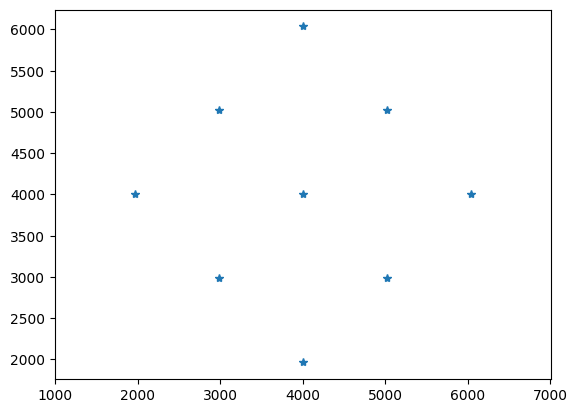

In [14]:
# Test plot
plt.plot(farmturb_xy[:,0], farmturb_xy[:,1], '*')
plt.axis('equal');

In [15]:

# Build the CSV input file of turbine layouts for amrwind-frontend
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
"""
rowformat="T%02i, %f, %f, IEA15MW_ALM, , ,%s\n"
for iturb, xy in enumerate(farmturb_xy):
    turboptions  = OFoptions+DISCON2p8_options
    # uncomment this line for AWC
    if iturb < NAWCTURBS:   turboptions += AWCoptions
    turbinescsv += rowformat%(iturb, xy[0], xy[1], turboptions)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [16]:
# Set up the domain 
case.setAMRWindInput('turbines_domainsize', farm_domainsize)
case.setAMRWindInput('turbines_backgroundmeshsize', farm_background_mesh)
case.setAMRWindInput('turbines_autocalccenter', False)
case.setAMRWindInput('turbines_farmcenter', [0, 0])
case.setAMRWindInput('turbines_deleteprev', True)
case.setAMRWindInput('turbines_createnewdomain', False)

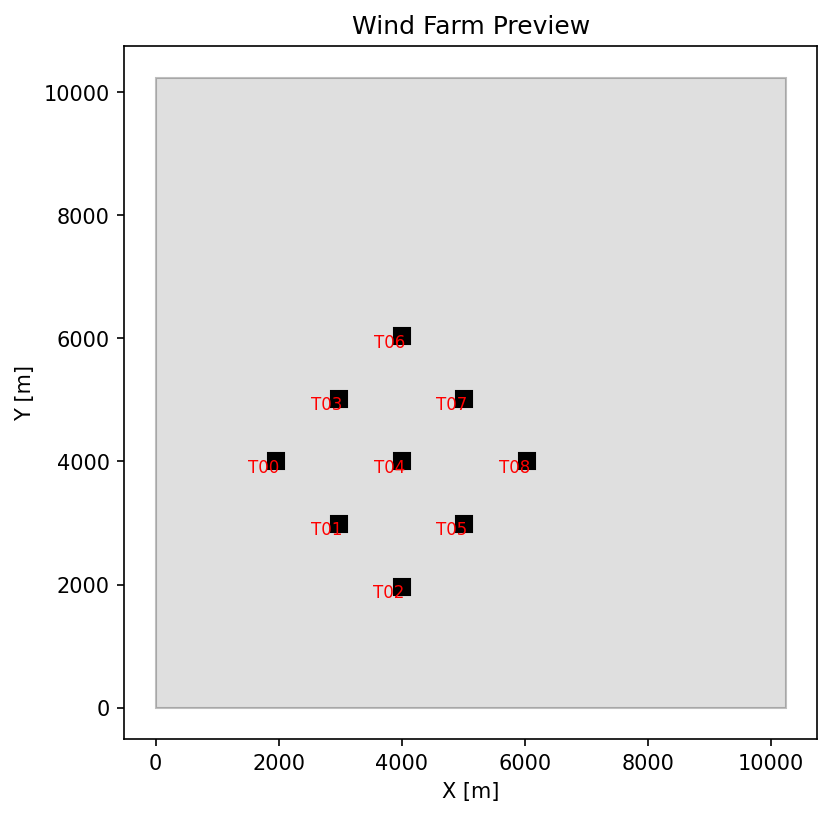

In [17]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

In [18]:
case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())
logrun(LOGFILE, 'Created turbines')

docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AdvancedControlsWakes/turbinemodels/OpenFAST3p5_IEA15MW to T00_OpenFAST3p5_IEA15MW
T00_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/ALCC_Frontier_WindFarm/farmruns/MedWS_LowTI/ABL_ALM_10x10/rundir_test/T00_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.245600 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
Setting Actuator_openfast_stop_time to 2000.0
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('DLL_FileName', '/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so'), ('DLL_InFile', 'IEA-15-240-RWT-Monopile_DISCON_2p8.IN')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), 

      45.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
    1.2456 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so DLL_FileName - Name/location of the dynamic library {.dll [Windows] or .so [Linux]} in the Bladed-DLL format (-) [used only with Bladed Interface] [EDITED]
IEA-15-240-RWT-Monopile_DISCON_2p8.IN DLL_InFile - Name of input file sent to the DLL (-) [used only with Bladed Interface] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmS

T01_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/ALCC_Frontier_WindFarm/farmruns/MedWS_LowTI/ABL_ALM_10x10/rundir_test/T01_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.245600 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
Setting Actuator_openfast_stop_time to 2000.0
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('DLL_FileName', '/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so'), ('DLL_InFile', 'IEA-15-240-RWT-Monopile_DISCON_2p8.IN')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /au

      45.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
    1.2456 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so DLL_FileName - Name/location of the dynamic library {.dll [Windows] or .so [Linux]} in the Bladed-DLL format (-) [used only with Bladed Interface] [EDITED]
IEA-15-240-RWT-Monopile_DISCON_2p8.IN DLL_InFile - Name of input file sent to the DLL (-) [used only with Bladed Interface] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmS

T02_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/ALCC_Frontier_WindFarm/farmruns/MedWS_LowTI/ABL_ALM_10x10/rundir_test/T02_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.245600 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
Setting Actuator_openfast_stop_time to 2000.0
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('DLL_FileName', '/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so'), ('DLL_InFile', 'IEA-15-240-RWT-Monopile_DISCON_2p8.IN')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /au

      45.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
    1.2456 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so DLL_FileName - Name/location of the dynamic library {.dll [Windows] or .so [Linux]} in the Bladed-DLL format (-) [used only with Bladed Interface] [EDITED]
IEA-15-240-RWT-Monopile_DISCON_2p8.IN DLL_InFile - Name of input file sent to the DLL (-) [used only with Bladed Interface] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmS

T03_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/ALCC_Frontier_WindFarm/farmruns/MedWS_LowTI/ABL_ALM_10x10/rundir_test/T03_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.245600 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
Setting Actuator_openfast_stop_time to 2000.0
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('DLL_FileName', '/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so'), ('DLL_InFile', 'IEA-15-240-RWT-Monopile_DISCON_2p8.IN')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /au

      45.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
    1.2456 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so DLL_FileName - Name/location of the dynamic library {.dll [Windows] or .so [Linux]} in the Bladed-DLL format (-) [used only with Bladed Interface] [EDITED]
IEA-15-240-RWT-Monopile_DISCON_2p8.IN DLL_InFile - Name of input file sent to the DLL (-) [used only with Bladed Interface] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmS

T04_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/ALCC_Frontier_WindFarm/farmruns/MedWS_LowTI/ABL_ALM_10x10/rundir_test/T04_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.245600 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
Setting Actuator_openfast_stop_time to 2000.0
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('DLL_FileName', '/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so'), ('DLL_InFile', 'IEA-15-240-RWT-Monopile_DISCON_2p8.IN')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /au

      45.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
    1.2456 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so DLL_FileName - Name/location of the dynamic library {.dll [Windows] or .so [Linux]} in the Bladed-DLL format (-) [used only with Bladed Interface] [EDITED]
IEA-15-240-RWT-Monopile_DISCON_2p8.IN DLL_InFile - Name of input file sent to the DLL (-) [used only with Bladed Interface] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmS

T05_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/ALCC_Frontier_WindFarm/farmruns/MedWS_LowTI/ABL_ALM_10x10/rundir_test/T05_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.245600 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
Setting Actuator_openfast_stop_time to 2000.0
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('DLL_FileName', '/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so'), ('DLL_InFile', 'IEA-15-240-RWT-Monopile_DISCON_2p8.IN')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /au

      45.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
    1.2456 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so DLL_FileName - Name/location of the dynamic library {.dll [Windows] or .so [Linux]} in the Bladed-DLL format (-) [used only with Bladed Interface] [EDITED]
IEA-15-240-RWT-Monopile_DISCON_2p8.IN DLL_InFile - Name of input file sent to the DLL (-) [used only with Bladed Interface] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmS

T06_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/ALCC_Frontier_WindFarm/farmruns/MedWS_LowTI/ABL_ALM_10x10/rundir_test/T06_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.245600 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
Setting Actuator_openfast_stop_time to 2000.0
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('DLL_FileName', '/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so'), ('DLL_InFile', 'IEA-15-240-RWT-Monopile_DISCON_2p8.IN')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /au

      45.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
    1.2456 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so DLL_FileName - Name/location of the dynamic library {.dll [Windows] or .so [Linux]} in the Bladed-DLL format (-) [used only with Bladed Interface] [EDITED]
IEA-15-240-RWT-Monopile_DISCON_2p8.IN DLL_InFile - Name of input file sent to the DLL (-) [used only with Bladed Interface] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmS

T07_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/ALCC_Frontier_WindFarm/farmruns/MedWS_LowTI/ABL_ALM_10x10/rundir_test/T07_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.245600 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
Setting Actuator_openfast_stop_time to 2000.0
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('DLL_FileName', '/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so'), ('DLL_InFile', 'IEA-15-240-RWT-Monopile_DISCON_2p8.IN')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
docopy = True from /au

      45.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
    1.2456 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so DLL_FileName - Name/location of the dynamic library {.dll [Windows] or .so [Linux]} in the Bladed-DLL format (-) [used only with Bladed Interface] [EDITED]
IEA-15-240-RWT-Monopile_DISCON_2p8.IN DLL_InFile - Name of input file sent to the DLL (-) [used only with Bladed Interface] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmS

T08_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
Fixing yaw in /autofs/nccs-svm1_proj/cfd162/lcheung/ALCC_Frontier_WindFarm/farmruns/MedWS_LowTI/ABL_ALM_10x10/rundir_test/T08_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_ElastoDyn.dat
MISMATCH between incflo.density = 1.245600 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
Setting Actuator_openfast_stop_time to 2000.0
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('DLL_FileName', '/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so'), ('DLL_InFile', 'IEA-15-240-RWT-Monopile_DISCON_2p8.IN')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
['T00', 'T01', 'T02', 

      45.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
    1.2456 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so DLL_FileName - Name/location of the dynamic library {.dll [Windows] or .so [Linux]} in the Bladed-DLL format (-) [used only with Bladed Interface] [EDITED]
IEA-15-240-RWT-Monopile_DISCON_2p8.IN DLL_InFile - Name of input file sent to the DLL (-) [used only with Bladed Interface] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmS

In [19]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     3200,     4000,       2000,    150,   200,   center:specified units:meter centerx:4000 centery:4000 centerz:150 name:A
#1,     1.0,      1.0,        1.00,  0.625,   1.0, 
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)
case.refine_createAllZones()

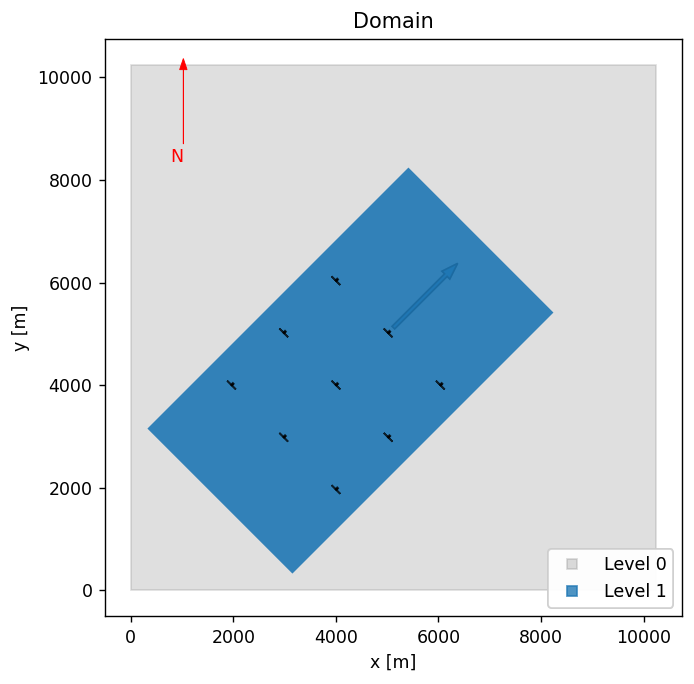

In [20]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
case.plotDomain(ax=ax)
logrun(LOGFILE, 'Created plot 1')

In [21]:
# This will print out your mesh size & refinements
case.estimateMeshSize()

Refinement A: level 1: 645120000 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0    805306368                5.0 x 5.0 x 5.0
       1    645120000                2.5 x 2.5 x 2.5
  TOTAL:   1450426368


## Add sampling

In [22]:
# Delete all old sampling planes from precursor
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()

In [23]:
outputoptions="outputvars:velocity;tke;temperature;p outputfreq:25"

turbsamplingcsv = """
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name,      type,       upstream, downstream, lateral, below, above, n1, n2, options
turbhh,    hubheight,  5,        5,         2,        0,     1.5,     11, 11, usedx:0.05 outputto:turbhh_ orientation:nacdir {outputoptions} noffsets:1
sw,        streamwise, 5,        5,         0,       0.625, 1.5,     11, 11, usedx:0.05 outputto:turbsw_  orientation:nacdir {outputoptions}
swA,       streamwise, 5,        5,         2,       0.625, 1.5,     11, 11, usedx:0.05 outputto:turbswA_  orientation:nacdir {outputoptions} noffsets:2
swB,       streamwise, 5,        5,        -2,       0.625, 1.5,     11, 11, usedx:0.05 outputto:turbswB_  orientation:nacdir {outputoptions} noffsets:2
rotor,     rotorplane, 5,        5,         2,       0.625, 1.5,     11, 11, usedx:0.05  outputto:rotor_   orientation:nacdir outputvars:velocity noffsets:10  {outputoptions}
rotorfine, rotorplane, 1,        1,         2,       0.625, 1.5,     11, 11, usedx:0.025 outputto:rotorfine_ orientation:nacdir outputvars:velocity noffsets:10  {outputoptions}
swdomain,  streamwise, 8,        8,         0,       0.625, 1.5,     11, 11, usedx:0.1  outputto:swdomain_ orientation:nacdir  center:farm wholedomain:1 {outputoptions}
turbdomain,hubheight,  8,        8,         2,       0,     1.5,     11, 11, usedx:0.1  outputto:turbdomain_ orientation:nacdir center:farm wholedomain:1  {outputoptions} noffsets:1

swdomain00, streamwise, 8,        8,         0,       0.625, 1.5,     11, 11, usedx:0.1  outputto:swdomain00_ orientation:nacdir  center:specified centerx:-6572.93506  centery:-2500.0      centerz:150  wholedomain:1 {outputoptions}
swdomain01, streamwise, 8,        8,         0,       0.625, 1.5,     11, 11, usedx:0.1  outputto:swdomain01_ orientation:nacdir  center:specified centerx:-5554.701295 centery:-3518.233765 centerz:150  wholedomain:1 {outputoptions}
swdomain03, streamwise, 8,        8,         0,       0.625, 1.5,     11, 11, usedx:0.1  outputto:swdomain03_ orientation:nacdir  center:specified centerx:-3518.233765 centery:-5554.701295 centerz:150  wholedomain:1 {outputoptions}
swdomain04, streamwise, 8,        8,         0,       0.625, 1.5,     11, 11, usedx:0.1  outputto:swdomain04_ orientation:nacdir  center:specified centerx:-2500.0      centery:-6572.93506  centerz:150  wholedomain:1 {outputoptions}
inoutflow,  rotorplane, 3000,     5000,   2500,       150,   360,     11, 11, usedx:10   outputto:inoutflow_  orientation:winddir center:specified centerx:4000 centery:4000 centerz:150 units:meter  {outputoptions} noffsets:8
sideflowA,  streamwise, 3000,     5000,   2500,       150,   360,     11, 11, usedx:10   outputto:sideflowA_  orientation:winddir center:specified centerx:4000 centery:4000 centerz:150 units:meter  {outputoptions} noffsets:5
sideflowB,  streamwise, 3000,     5000,  -2500,       150,   360,     11, 11, usedx:10   outputto:sideflowB_  orientation:winddir center:specified centerx:4000 centery:4000 centerz:150 units:meter  {outputoptions} noffsets:5
turbuptipdomain, hubheight,  8,        8,         2,        0.5,   1.5,    11, 11, usedx:0.1 outputto:turbuptipdomain_ orientation:nacdir center:specified centerx:4000 centery:4000 centerz:270 wholedomain:1 {outputoptions} 
turbuptip, hubheight,  3000,      5000,   2500,       0.5,   1.5,    11, 11, usedx:10 outputto:turbuptip_ orientation:nacdir center:specified centerx:4000 centery:4000 centerz:270 units:meter {outputoptions} 
turb1Duptip, hubheight,  3000,      5000,   2500,       0.5,   1.5,    11, 11, usedx:10 outputto:turb1Duptip_ orientation:nacdir center:specified centerx:4000 centery:4000 centerz:390 units:meter {outputoptions} 
turb1p5Duptip, hubheight,3000,      5000,   2500,       0.5,   1.5,    11, 11, usedx:10 outputto:turb1p5Duptip_ orientation:nacdir center:specified centerx:4000 centery:4000 centerz:510 units:meter {outputoptions} 
turbbottip, hubheight,  3000,      5000,   2500,       0.5,   1.5,    11, 11, usedx:10 outputto:turbbottip_ orientation:nacdir center:specified centerx:4000 centery:4000 centerz:30 units:meter {outputoptions} 
""".format(outputoptions=outputoptions)

case.setAMRWindInput('sampling_csvtextbox', turbsamplingcsv)
case.setAMRWindInput('sampling_deleteprev', True)

In [24]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())
logrun(LOGFILE, 'Created sampling planes')

['T00_turbhh', 'T01_turbhh', 'T02_turbhh', 'T03_turbhh', 'T04_turbhh', 'T05_turbhh', 'T06_turbhh', 'T07_turbhh', 'T08_turbhh', 'T00_sw', 'T01_sw', 'T02_sw', 'T03_sw', 'T04_sw', 'T05_sw', 'T06_sw', 'T07_sw', 'T08_sw', 'T00_swA', 'T01_swA', 'T02_swA', 'T03_swA', 'T04_swA', 'T05_swA', 'T06_swA', 'T07_swA', 'T08_swA', 'T00_swB', 'T01_swB', 'T02_swB', 'T03_swB', 'T04_swB', 'T05_swB', 'T06_swB', 'T07_swB', 'T08_swB', 'T00_rotor', 'T01_rotor', 'T02_rotor', 'T03_rotor', 'T04_rotor', 'T05_rotor', 'T06_rotor', 'T07_rotor', 'T08_rotor', 'T00_rotorfine', 'T01_rotorfine', 'T02_rotorfine', 'T03_rotorfine', 'T04_rotorfine', 'T05_rotorfine', 'T06_rotorfine', 'T07_rotorfine', 'T08_rotorfine', 'Farm_swdomain', 'Farm_turbdomain', 'Farm_swdomain00', 'Farm_swdomain01', 'Farm_swdomain03', 'Farm_swdomain04', 'Farm_inoutflow', 'Farm_sideflowA', 'Farm_sideflowB', 'Farm_turbuptipdomain', 'Farm_turbuptip', 'Farm_turb1Duptip', 'Farm_turb1p5Duptip', 'Farm_turbbottip']


## Plot the domain

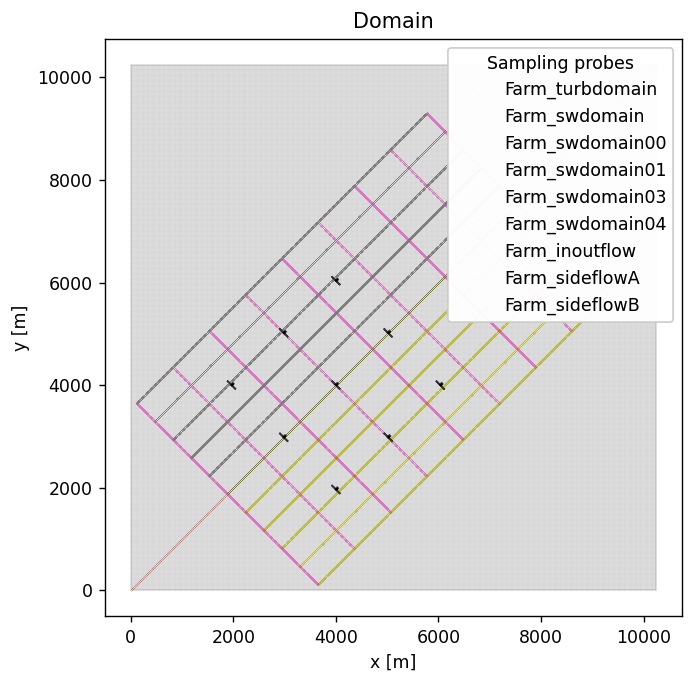

In [25]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['Farm_turbdomain' , 'Farm_swdomain',  'Farm_swdomain00', 'Farm_swdomain01', 
                                                                'Farm_swdomain03', 'Farm_swdomain04', 'Farm_inoutflow', 'Farm_sideflowA', 'Farm_sideflowB',]
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':0.01, 'marker':'.', 'linestyle':'None','alpha':0.25, }"
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
case.plotDomain(ax=ax)
logrun(LOGFILE, 'Created plot 2')

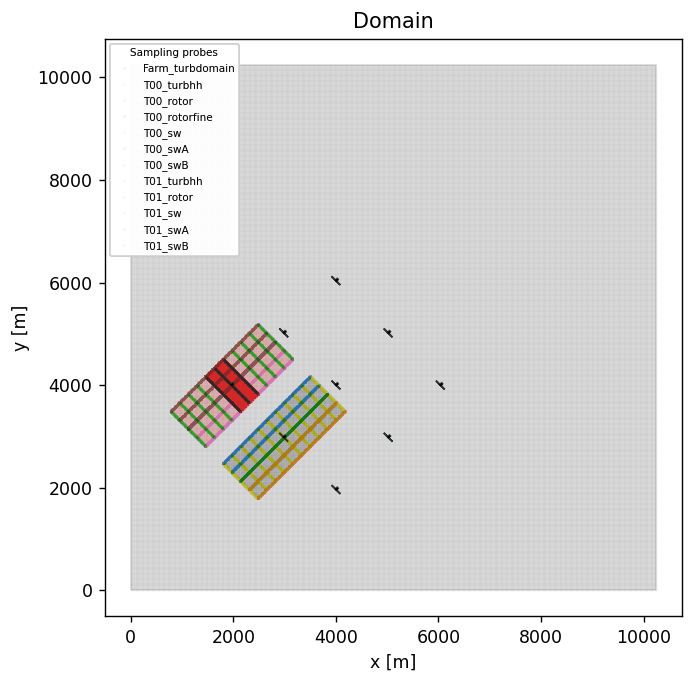

In [26]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['Farm_turbdomain' , 'T00_turbhh', 'T00_rotor', 'T00_rotorfine','T00_sw' , 'T00_swA', 'T00_swB',
                                                                'T01_turbhh', 'T01_rotor', 'T01_sw', 'T01_swA', 'T01_swB',]
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':0.01, 'marker':'.', 'linestyle':'None','alpha':0.75}"
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend']= "{'title':'Sampling probes', 'fontsize':6, 'loc':'upper left', 'markerscale':10}"
case.plotDomain(ax=ax)
#ax.set_xlim([-10000, -5000])
#ax.set_ylim([-5000, 0])
logrun(LOGFILE, 'Created plot 3')

In [27]:
print(case.popup_storteddata['plotdomain'])

OrderedDict([('plot_chooseview', 'XY'), ('plot_windnortharrows', False), ('plot_lidar_Ntime', 101), ('plot_sampleprobes_style', "{'markersize':0.01, 'marker':'.', 'linestyle':'None','alpha':0.75}"), ('plot_sampleprobes_legend', "{'title':'Sampling probes', 'fontsize':6, 'loc':'upper left', 'markerscale':10}"), ('plot_refineboxes_legend', "{'frameon':True, 'numpoints':1, 'fontsize':10, 'loc':'lower right'}"), ('plot_sampleprobes', ['Farm_turbdomain', 'T00_turbhh', 'T00_rotor', 'T00_rotorfine', 'T00_sw', 'T00_swA', 'T00_swB', 'T01_turbhh', 'T01_rotor', 'T01_sw', 'T01_swA', 'T01_swB']), ('plot_refineboxes', []), ('plot_turbines', ['T00', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T08'])])


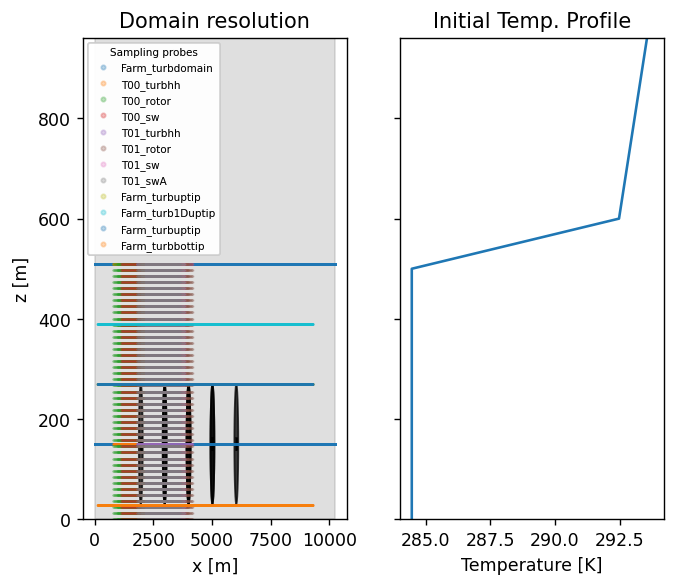

In [28]:
fig, axs = plt.subplots(1,2, figsize=(6,5), facecolor='w', dpi=125, sharey=True)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['Farm_turbdomain' , 'T00_turbhh', 'T00_rotor', 'T00_sw' , 'T01_turbhh', 'T01_rotor', 'T01_sw', 'T01_swA', #'Farm_swdomain', 
                                                                'Farm_turbuptip', 'Farm_turb1Duptip', 'Farm_turbuptip', 'Farm_turbbottip', #'Farm_inoutflow'
                                                               ]
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XZ' 
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':0.5, 'marker':'.', 'linestyle':'None','alpha':0.25}"
case.plotDomain(ax=axs[0])
axs[0].set_title('Domain resolution')
axs[0].axis('auto')
axs[0].set_ylim([0,960])

case.plotGenericProfile('ABL.temperature_values', 'ABL.temperature_heights', ax=axs[1])
axs[1].set_ylim([0,960])
#axs[1].axis('scaled')
axs[1].set_xlabel('Temperature [K]')
axs[1].set_title('Initial Temp. Profile')
logrun(LOGFILE, 'Created plot 4')

In [29]:
# Check that all inputs are okay
check=case.validate()

-- Checking inputs --
[ PASS] max_level:           max_level = 1 >= 0
[ PASS] dt & CFL:            DT and CFL OK
[ PASS] restart dir:         Restart directory /lustre/orion/cfd162/proj-shared/lcheung/ALCC_Frontier_WindFarm/precursor/MedWS_LowTI_10kmX10km/chk100000 exists
[ PASS] boundary plane dir:  Restart directory /lustre/orion/cfd162/proj-shared/lcheung/ALCC_Frontier_WindFarm/precursor/MedWS_LowTI_10kmX10km/bndry_data/ exists
[ PASS] Actuator physics:    incflo.physics and ICNS.source_terms OK for Actuators
[ PASS] Actuator FST:T00     [T00_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst] exists
[ PASS] Actuator FST:T00     Actuator density=1.245600, matches incflo.density=1.245600
[ PASS] Actuator FST:T00     CompInflow OK
[ PASS] Actuator FST:T00     [T00_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_AeroDyn15.dat] exists
[ PASS] Actuator FST:T00     WakeMod=0 OK
[ PASS] Actuator FST:T00     AirDens=1.245600, matches incflo.density=1

In [30]:
# Write the input file
print(case.writeAMRWindInput(outputfile))
logrun(LOGFILE, 'Wrote '+outputfile)

# --- Simulation time control parameters ---
time.stop_time                           = 25900.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.02                # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 1000                
time.checkpoint_start                    = 100000              
incflo.physics                           = ABL Actuator        # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
io.restart_file                          = /lustre/orion/cfd162/proj-shared/lcheung/ALCC_Frontier_WindFarm/precursor/MedWS_LowTI_10kmX10km/chk100000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence

In [31]:
# Create a version without turbines
case.removeturbines()
inputfile=case.writeAMRWindInput(noturboutputfile)
os.chdir(cwd)
logrun(LOGFILE, 'Done')
#if verbose: print(inputfile)